# Training Feed Forward Neural Network (on GPU if cuda is availaible)

importing libraries

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

Downloading training and test dataset of MNIST

In [2]:
train_dataset = MNIST(root='data/MNIST/train/',train=True,transform=ToTensor(),download=True)
test_dataset = MNIST(root='data/MNIST/test/',train=False,transform=ToTensor(),download=True)

Let's look at a couple of images from the dataset. The images are converted to PyTorch tenosrs with the shape `1x28x28`( the dimensions represent color channels, width and height). We can use `plt.imshow` to display the images. However, `plt.imshow` expects channels to be last dimension in an image tensor, so we use the permute method to reorder the dimension of the image

Image.shape : torch.Size([1, 28, 28])
Label : 5


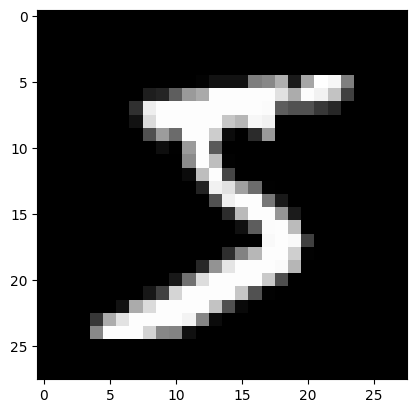

In [3]:
image, label = train_dataset[0]
print(f'Image.shape : {image.shape}')
plt.imshow(image.permute(1,2,0),cmap='gray')
# plt.imshow(image[0],cmap='gray')
print(f'Label : {label}')

Next, let's use the `random_split` helper function to set aside 10,000 images for out validation set.

In [4]:
val_size = 10000
train_size = len(train_dataset) - val_size

train_ds, val_ds = random_split(train_dataset, [train_size,val_size])
len(train_ds), len(val_ds)

(50000, 10000)

We czn now create PyTorch data loaders for training and validation

In [5]:
batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4,pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

Setting argument `num_workers` as positive integer will turn on multi-process data loading with the specified number of loader worker processes.
For data loading, passing `pin_memory`= True to a `DataLoader` will automatically put the fetched data Tensor in pinned memory, and thus enables faster data transfer to CUDA-enabled GPUs.

Let's bisualize a batch of data in a grid using the `make_grid` function from `torchvision`. We'll also use the `.permute` method on the tensor to move the channels to the last dimension, as expected by `matplotlib.imshow`.

images.shape : torch.Size([128, 1, 28, 28])


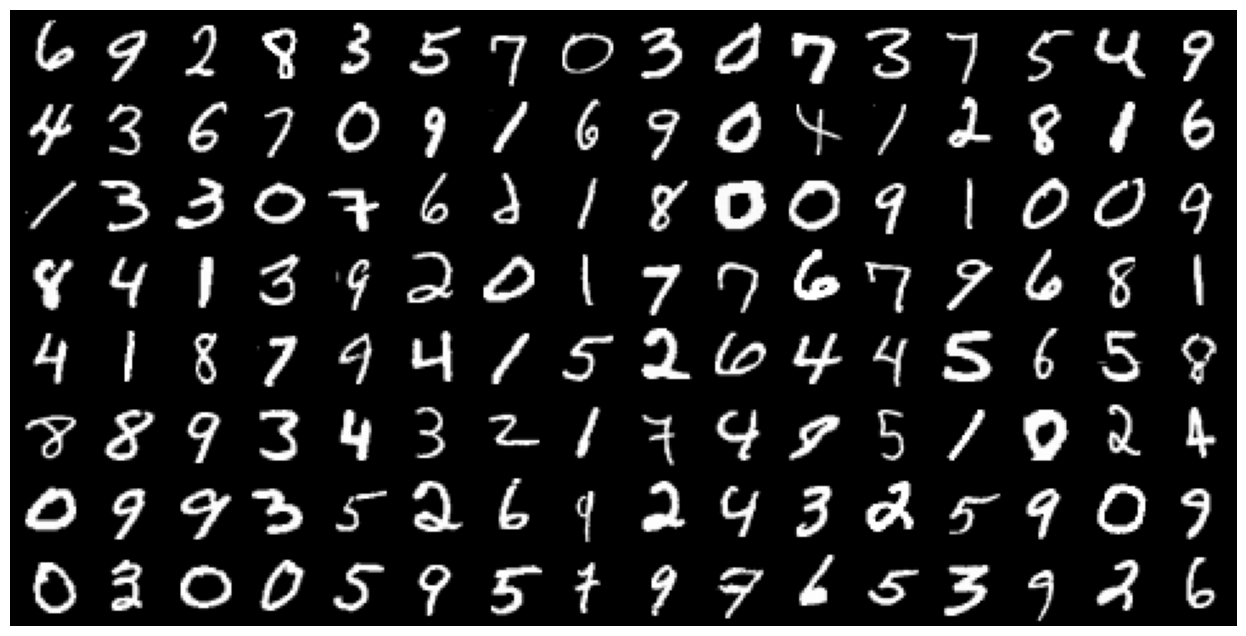

In [6]:
for images,_ in train_loader:
    print(f'images.shape : {images.shape}')
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images,nrow=16).permute(1,2,0))
    break


### Hidden Layers, Activation Functions and Non-Linearity

We'll create a neural network with two layers: a hidden layer and an output layer. Additionally, we'll use an activation function between the two layers. Let's look at a step-by-step example to learn how hidden layers and activation functions can help capture non-linear relationships between inputs and outputs.

First, let's create a batch of input tensors . We'll flatten the `1x28x28` images into vector of size `784`, so they can be passed into an `nn.Linear` object

In [7]:
for images, labels in train_loader:
    print(f'images.shape : {images.shape}')
    inputs = images.reshape(-1,784)
    print(f'inputs.shape : {inputs.shape}')
    break

images.shape : torch.Size([128, 1, 28, 28])
inputs.shape : torch.Size([128, 784])


Next, let's create a `nn.Linear` object, which will serve as our hidden layer. We'll set the size of the output from the hidden layer to 32. This number can be increased or decreased to change the learning capacity of the model.

In [8]:
input_size = inputs.shape[-1]
hidden_size = 32

layer1 = nn.Linear(input_size, hidden_size)

We can now compute intermediate outputs for the batch of images by passing `inputs` through `layer1`

In [9]:
print(inputs.shape)

layer1_outputs = layer1(inputs)
print(f'layer1_outputs.shape : {layer1_outputs.shape}')

torch.Size([128, 784])
layer1_outputs.shape : torch.Size([128, 32])


The image vector of size `784` are transformed into intermediate output vector of length `32` by performing a matrix multiplication of `inputs` matrix with the transposed weights matrix of `layer1` and adding the bias. We can verify this using `torch.allclose`.

In [10]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [11]:
torch.allclose(layer1_outputs,layer1_outputs_direct,1e-3)

True

Thus, `layer1_outputs` and `inputs` have a linear relationship, i.e, eadch element of `layer1_outputs` is a weighted sum of elements from `inputs`. Thus, even as we train the model and modify the weights, `layer1` can only capture linear relationships between `inputs` and `outputs`.

Next, we'll use the Rectified Linear Unit (ReLU) function as the activation function for the outputs. It has the formula `relu(x) = max(0,x)` i.e., it simply replaces negarive values in a given tensor with the value 0. ReLU is a non-linear function.\

We can use `F.relu` method to apply ReLU to the elements of a tensor.

In [12]:
F.relu(torch.tensor([[1,-1,0],[-0.1,0.2,3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

Let's apply the activation function to `layer1_outputs` and verify that negarive values were replaced with 0.

In [13]:
relu_outputs = F.relu(layer1_outputs)
print(f'min(layer1_outputs) : {torch.min(layer1_outputs).item()}')
print(f'min(relu_outputs) : {torch.min(relu_outputs).item()}')

min(layer1_outputs) : -0.6266122460365295
min(relu_outputs) : 0.0


Now that we've applied a non-linear activation function, `relu_outputs` and `inputs` do not have a linear relationship. We refer to `ReLU` as the activation function, because for each input certain outputs are activated (those with non-zero values) while others turned off ( those with zero values)

Next let's create an output layer to convert vectors of length `hidden_size` in `relu_outputs` into vectors of length 10, which is the desired output of our model (since there are 10 target labels.)

In [14]:
output_size = 10
layer2 = nn.Linear(hidden_size,output_size)

In [15]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


As expected, `layer2_outputs` contains a batch of vectors of size 10. We can now use this output to compute the loss using `F.corss_entropy` and adjust the weights of `layer1` and `layer2` using gradient descent.

In [16]:
F.cross_entropy(layer2_outputs,labels)

tensor(2.3143, grad_fn=<NllLossBackward0>)

In [17]:
# Expanded version of layer2(F.relu(layer1(inputs)))
outputs = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias

In [18]:
torch.allclose(outputs,layer2_outputs,1e-3)

True

Note that `outputs` and `inputs` do not have a linear relationship due to the non-linear activation function `F.relu`. As we train the model and adjust the weights of `layer1` and `layer2`, we can now capture non-linear relationship between the images and their labels. In other words, introducing non-linearity makes the model more powerful and versitile. Also, since `hidden_size` does not depend on the dimensions of the inputs or outputs, we vary it to increase the number of parameters within the model. We can also introduce new hidden layers and apply the same non-linear activation after each hidden layer.

The model we just created is called a neural network. A deep neural network is simply a neural network with one or more hidden layers.

In fact, the Universal Approximation Theorem states that a sufficiently large and deep neural network can compute any arbitary function, i.e., it can learn rich and complex non-linear relationships between inputs and targets. 

If we hadn't included a non-linear activarion between the two linear layers, the final relationship between inputs and outputs would still be linear. A simple refacotoring of the computations illustrate this.

In [19]:
# Same as layer2(layer1(inputs))
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias

In [20]:
#  Create a single layer to replace the two linear layers
combined_layer = nn.Linear(input_size, output_size)

combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

In [21]:
# same as combined layer(inputs)
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

In [22]:
torch.allclose(outputs2,outputs3,1e-3)

True

## Model 

we are now ready to define our model. We'll create a neural network with one hidden layer.
     
     
1. Instead of using a single `nn.Linear` object to transfrom a batch of inputs (pixel intensities) into outputs (class probabilities), we'll use two `nn.Linear` objects. Each of these is called a layer in the network.

2. The first layer (also known as the hidden layer) will transform the input matrix of the shape `batch_size x 784` into an intermediate output matrix of shape `batch_size x hidden_size`. The parameter `hidden_size` can be configured manually (e.g., 32 or 64).

3. We'll then apply a non-linear activation function to the intermediate outputs. The activation function transforms individual elements of the matrix.

4. The result of the activation function, which is also of size `batch_size x hidden_size`, is passed into the second layer (also known as the output layer). The second layer transforms it into a matrix of size `batch_size x 10`. We can use this output to compute the loss and adjust weights using gradient descent.

In [23]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs ,dim = 1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

We defined an `accuracy` function which calculates the accuracy of the model's prediction on an batch of inputs. It's used in `validation_step` 

In [24]:
class MnistModel(nn.Module):
    '''Feedforward neural network with 1 hidden layer'''
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        #hidden layer
        self.layer1 = nn.Linear(in_size, hidden_size)
        #output layer
        self.layer2 = nn.Linear(hidden_size, out_size)

    def forward(self , xb):
        # Flattening the image tensor
        xb = xb.view(xb.size(0),-1)
        # Get intermediate outputs using hidden layer
        out = self.layer1(xb)
        # Applying activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.layer2(out)

        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out,labels)  # Calculate loss

        return loss

    def validation_step(self,batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)         # calculate accuracy

        return {'val_loss' : loss, 'val_acc' : acc}
    
    def validation_epoch_end(slef, outputs):
        batch_losses = []
        batch_accs = []

        for x in outputs:
            batch_losses.append(x['val_loss'])
            batch_accs.append(x['val_acc'])

        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        epoch_acc = torch.stack(batch_accs).mean()      # combine accuracies

        return {'val_loss' : epoch_loss.item(), 'val_acc' : epoch_acc.item()} 
    
    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch+1}], val_loss : {result['val_loss']}, val_acc : {result['val_acc']}")

We'll create  a model that contains a hidden layer with 32 activations.

In [25]:
input_size = 784
hidden_size = 32
num_classes = 10

In [26]:
model = MnistModel(input_size, hidden_size, num_classes)

Let's take a look at the model's parameters. We expect to see one weight and bias matrix for each of the layers.

In [27]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


Let's try and generate some outputs using our model. We'll take the first batch of 128 images from out dataset and pass them into our model.

In [28]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs,labels)
    print(f'Loss : {loss.item()}')
    break

print(f'outputs.shape : {outputs.shape}')
print(f'sample outputs : {outputs[:2].data}')

Loss : 2.3455605506896973
outputs.shape : torch.Size([128, 10])
sample outputs : tensor([[-0.0251, -0.1840, -0.0325, -0.0369, -0.1729, -0.1274, -0.0418,  0.1492,
          0.2813,  0.0996],
        [-0.0471, -0.1033, -0.0352, -0.0612, -0.1034, -0.1395, -0.0201,  0.0807,
          0.1718, -0.0426]])


## Using a GPU

As the size of out models and datasets increase, we need to use GPU's to train our models with a reasonable amount of time. GPUs contain hundreds of cores optimized for performing expensive matrix operations on floating-point numbers quickly, making them ideal for training deep neural networks. You can use GPUs for free on "Google Colab" and "Kaggle"

We can check if GPU is availaible and the required NVIDIA CUDA drivers are installed using ` torch.cuda.is_availaible`

In [29]:
print(torch.cuda.is_available())

False


In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

cpu


In [31]:
for images, labels in train_loader:
    print(image.shape)
    images = images.to(device, non_blocking=True)
    print(images.device)
    break

torch.Size([1, 28, 28])
cpu


Finally, we defina a `DeviceDataLoader` class to wrap our existing data loaders and move batches of data to the selected device. Intrestingly, we don't need to extend class to create a PyTorch data loader All we need is an `__iter__` method to retrive batches of data and an `__len__` method to get the number of batches.

In [32]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x,device) for x in data]
    
    return data.to(device, non_blocking = True)

In [33]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)

    def __len__(self):
        return len(self.dl)

The `yield` keyword in python is used to create a generator function that can be used within a `for` loop.

We can now wrap our data loaders using `DeviceDataLoader`

In [34]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader,device)

Tensors moved to GPU have a `device` property which includes that word `cuda`. Let's verify this by looking at a batch of data from `valid_ld`.

In [35]:
for xb,yb in val_loader:
    print(f'xb.device : {xb.device}')
    print(f'yb : {yb}')
    break

xb.device : cpu
yb : tensor([1, 5, 7, 0, 4, 5, 9, 2, 3, 1, 4, 9, 2, 1, 9, 9, 6, 5, 9, 7, 5, 7, 7, 7,
        4, 0, 9, 0, 1, 1, 1, 9, 0, 4, 9, 6, 3, 6, 6, 6, 7, 8, 1, 6, 7, 1, 9, 2,
        6, 8, 3, 5, 0, 9, 1, 8, 8, 2, 2, 8, 9, 0, 5, 1, 9, 5, 4, 9, 8, 4, 5, 4,
        4, 6, 0, 3, 8, 7, 6, 2, 0, 2, 7, 7, 0, 2, 1, 2, 6, 2, 9, 8, 7, 6, 3, 5,
        0, 9, 5, 2, 3, 8, 4, 3, 3, 7, 6, 9, 5, 1, 6, 1, 5, 8, 5, 2, 6, 5, 4, 0,
        2, 9, 6, 8, 8, 0, 8, 7, 8, 9, 1, 0, 0, 8, 3, 2, 7, 4, 7, 8, 1, 8, 8, 8,
        8, 9, 8, 5, 1, 0, 5, 0, 9, 3, 4, 3, 1, 8, 9, 5, 4, 2, 3, 2, 3, 8, 1, 0,
        7, 7, 4, 3, 0, 0, 1, 0, 7, 6, 7, 5, 4, 1, 2, 4, 5, 6, 4, 3, 7, 3, 4, 5,
        6, 1, 7, 8, 7, 1, 5, 1, 7, 0, 0, 2, 9, 9, 3, 6, 5, 4, 6, 4, 4, 7, 2, 3,
        1, 0, 2, 2, 0, 9, 0, 6, 9, 9, 9, 1, 4, 4, 9, 0, 1, 0, 7, 5, 0, 0, 6, 2,
        5, 3, 4, 9, 0, 0, 5, 1, 9, 2, 4, 8, 1, 3, 9, 8])


## Training the model

We'll define two fucntions : `fit` and `evaluate` to train the model using gradient descent and evaluae its performance on the validation set.

In [36]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]

    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)

    for epoch in range(epochs):
        # Training phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

Before we train the model, we need to ensure that the data and the model's parameters (weights and biases) are on the same device (CPU or GPU). We can reuse the `to_device` function to move the model's parameters to the right device.

In [37]:
model = MnistModel(input_size, hidden_size, num_classes)
to_device(model,device)

MnistModel(
  (layer1): Linear(in_features=784, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=10, bias=True)
)

Let's see how the model performs on the validation set with the initial set of weights and biases.

In [38]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.304129123687744, 'val_acc': 0.12724609673023224}]

Let's train out model for 5 epochs with learning rate 0.5

In [39]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [1], val_loss : 0.23761287331581116, val_acc : 0.931640625
Epoch [2], val_loss : 0.17605052888393402, val_acc : 0.9486328363418579
Epoch [3], val_loss : 0.14865493774414062, val_acc : 0.9540039300918579
Epoch [4], val_loss : 0.14258718490600586, val_acc : 0.957812488079071
Epoch [5], val_loss : 0.12890300154685974, val_acc : 0.9610351324081421


Let's train the model for five more epochs at a lower learning rate of 0.1 to improve the accuracy further.

In [40]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [1], val_loss : 0.11287468671798706, val_acc : 0.9662109613418579
Epoch [2], val_loss : 0.11166258156299591, val_acc : 0.96728515625
Epoch [3], val_loss : 0.1136842593550682, val_acc : 0.9637695550918579
Epoch [4], val_loss : 0.11131791770458221, val_acc : 0.965039074420929
Epoch [5], val_loss : 0.11161589622497559, val_acc : 0.965527355670929


We can now plot the losses and accuracies to study how the model improves over time.

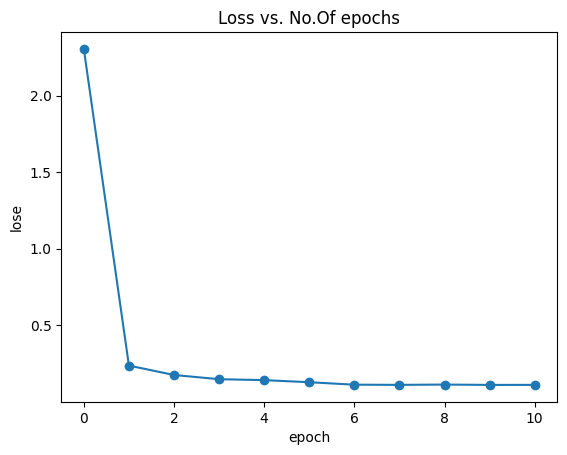

In [41]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-o')
plt.xlabel('epoch')
plt.ylabel('lose')
plt.title('Loss vs. No.Of epochs');

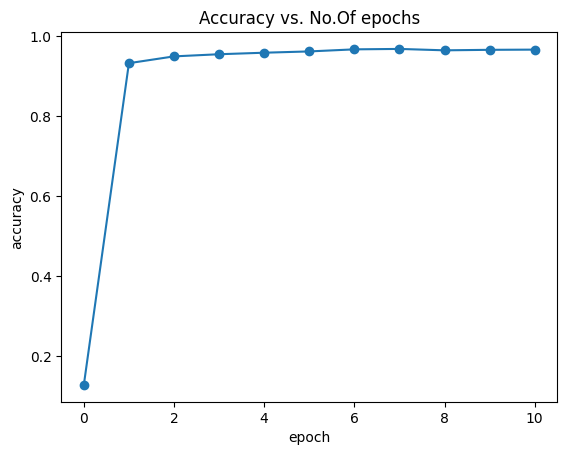

In [42]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No.Of epochs');

## Testing with individual images

In [43]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0),device)
    yb = model(xb)
    _,preds = torch.max(yb, dim = 1)

    return preds[0].item()

Let's try it out with a few images

Label : 7, predicted : 7


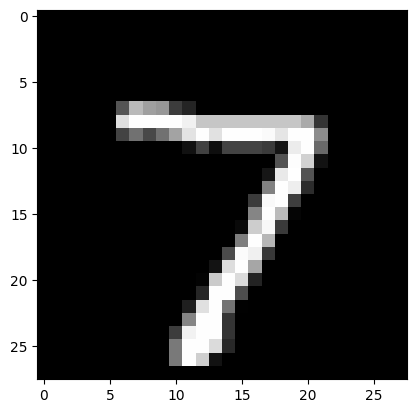

In [44]:
img, label = test_dataset[0]
plt.imshow(img[0],cmap='gray')
print(f'Label : {label}, predicted : {predict_image(img, model)}')

Label : 2, predicted : 2


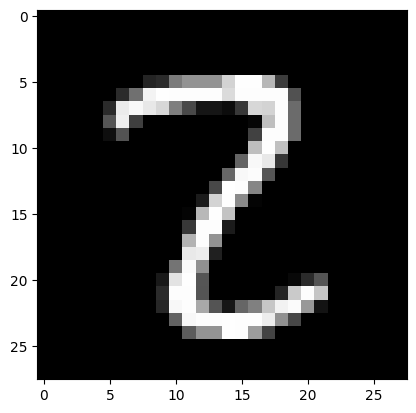

In [45]:
img, label = test_dataset[1839]
plt.imshow(img[0],cmap='gray')
print(f'Label : {label}, predicted : {predict_image(img, model)}')

Label : 9, predicted : 9


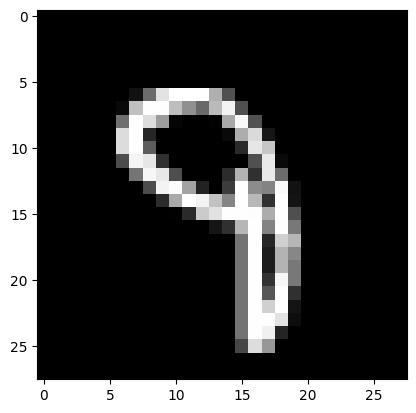

In [46]:
img, label = test_dataset[193]
plt.imshow(img[0],cmap='gray')
print(f'Label : {label}, predicted : {predict_image(img, model)}')

Let's look at the overall loss and accuracy of the model of the test set.

In [47]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256),device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.10147696733474731, 'val_acc': 0.969921886920929}

In [48]:
torch.save(model.state_dict(),'models/mnist-feedforward.pth')